In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [40]:
import mle.tsa as mle_tsa

Importing plotly failed. Interactive plots will not work.


In [2]:
plt.style.use('seaborn')
plt.rcParams.update({'figure.figsize': (16,8)})
sns.set_context("talk")

In [16]:
INPATH = "data/"
INFILE1 = "EIA_Europe_Brent_Spot_Price_FOB.csv"
INFILE2 = "EIA_Cushing_OK_WTI_Spot_Price_FOB.csv"

In [17]:
brent = pd.read_csv(INPATH + INFILE1, skiprows=4, parse_dates=['Day'], index_col='Day').sort_index()
brent.index.name = 'Date'
brent.columns = ['brent']
brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8400 entries, 1987-05-20 to 2020-06-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   brent   8400 non-null   float64
dtypes: float64(1)
memory usage: 131.2 KB


In [18]:
wti = pd.read_csv(INPATH + INFILE2, skiprows=4, parse_dates=['Day'], index_col='Day').sort_index()
wti.index.name = 'Date'
wti.columns = ['wti']
wti.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8688 entries, 1986-01-02 to 2020-06-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wti     8688 non-null   float64
dtypes: float64(1)
memory usage: 135.8 KB


In [19]:
data = brent
data['wti'] = wti

In [20]:
data['brent_diff5'] = (data['brent'] - data['brent'].shift(5)) / data['brent']
data['brent_fret5'] = (data['brent'].shift(-5) - data['brent'])/data['brent']

In [21]:
data['brent_mave5'] = data['brent'].rolling(10).mean()
data['brent_mstd5'] = data['brent'].rolling(10).std()
data['brent_z_std'] = (data['brent']-data['brent_mave5'])/data['brent_mstd5']

In [28]:
data['brent_mave20'] = data['brent'].rolling(20).mean()
data['brent_mave60'] = data['brent'].rolling(60).mean()
data['brent_mstd20'] = data['brent'].rolling(20).std()
data['brent_z_std'] = (data['brent']-data['brent_mave20'])/data['brent_mstd20']

data['brent_plus_1sigma'] = data['brent_mave20'] + data['brent_mstd20']
data['brent_minus_1sigma'] = data['brent_mave20'] - data['brent_mstd20']

data['brent_plus_2sigma'] = data['brent_mave20'] + 2*data['brent_mstd20']
data['brent_minus_2sigma'] = data['brent_mave20'] - 2*data['brent_mstd20']

data = data.dropna()['2013':].copy()

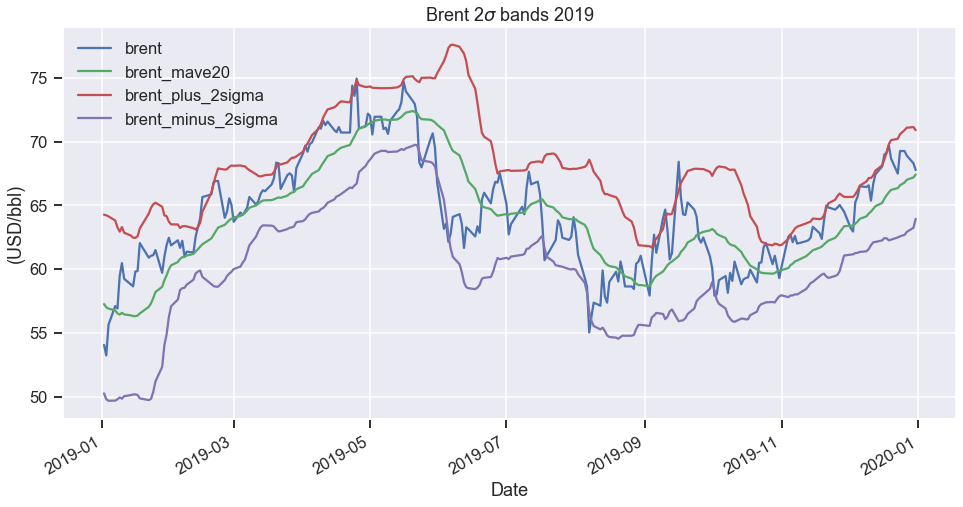

In [97]:
data['2019'].plot(y=['brent', 'brent_mave20', 'brent_plus_2sigma', 'brent_minus_2sigma'])
plt.title(r'Brent 2$\sigma$ bands 2019')
plt.ylabel('(USD/bbl)')
plt.show()

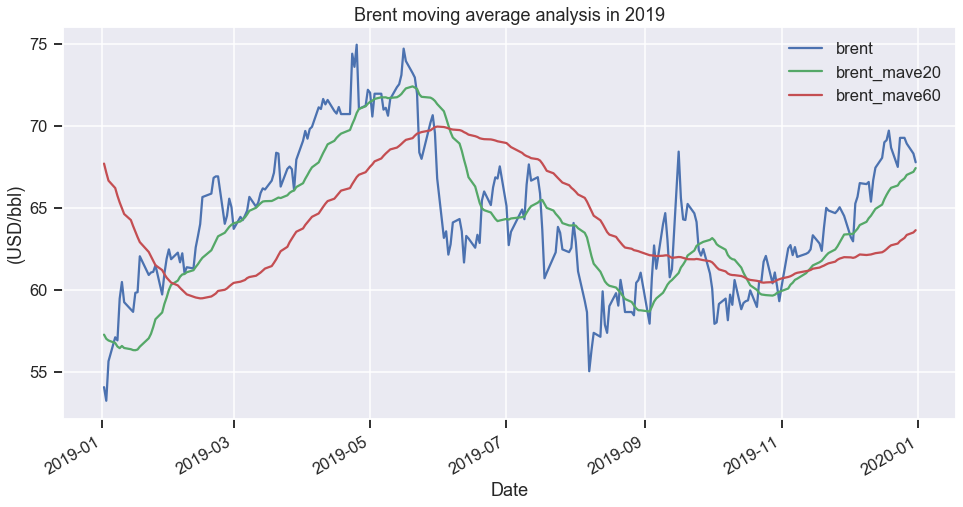

In [98]:
data['2019'].plot(y=['brent', 'brent_mave20', 'brent_mave60'])
plt.title('Brent moving average analysis in 2019')
plt.ylabel('(USD/bbl)')
plt.show()

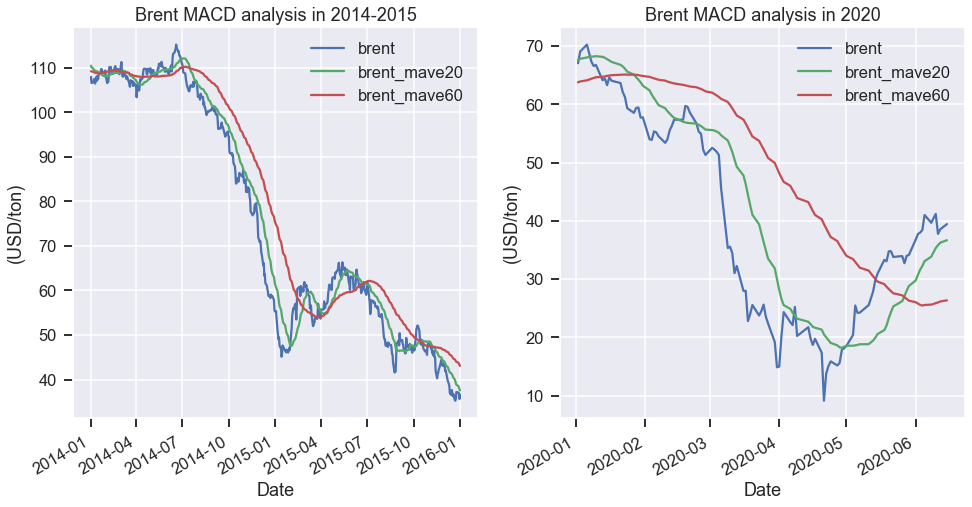

In [31]:
fig, axs = plt.subplots(1,2)

data['2014': '2015'].plot(y=['brent', 'brent_mave20', 'brent_mave60'], ax=axs[0])
axs[0].set_title('Brent MACD analysis in 2014-2015')

data['2020'].plot(y=['brent', 'brent_mave20', 'brent_mave60'], ax=axs[1])
axs[1].set_title('Brent MACD analysis in 2020')

for ax in axs:
    ax.set_ylabel('(USD/ton)')
plt.show()

In [34]:
brent_vs_wti_lr = sm.OLS(data['brent'], data['wti'])
brent_vs_wti_lr = brent_vs_wti_lr.fit()
brent_vs_wti_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  brent   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          7.819e+05
Date:                Sat, 27 Jun 2020   Prob (F-statistic):                        0.00
Time:                        20:08:11   Log-Likelihood:                         -4780.0
No. Observations:                1804   AIC:                                      9562.
Df Residuals:                    1803   BIC:                                      9568.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wti            1.0759      0.001    884.249      0.000       1.074       1.078
==============================================================================
Omnibus:                     1389.895   Durbin-Watson:                   0.427
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           135463.736
Skew:                           2.905   Prob(JB):                         0.00
Kurtosis:                      45.053   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
data['r_brent_vs_wti'] = brent_vs_wti_lr.resid

In [48]:
mle_tsa.wrap_adfuller(data[['r_brent_vs_wti']], regression='c')

r_brent_vs_wti: p-value: 0.00


{'r_brent_vs_wti': (-4.43150100832855,
  0.00026096169815469024,
  19,
  1784,
  {'1%': -3.4340208151070124,
   '5%': -2.8631614607057587,
   '10%': -2.5676332144347365},
  7296.972562480996)}

In [82]:
data.loc['2018':'2019', 'r_brent_vs_wti'].describe()

count    496.000000
mean       2.099594
std        2.547512
min       -7.359551
25%        0.448744
50%        2.391544
75%        3.910005
max        9.230397
Name: r_brent_vs_wti, dtype: float64

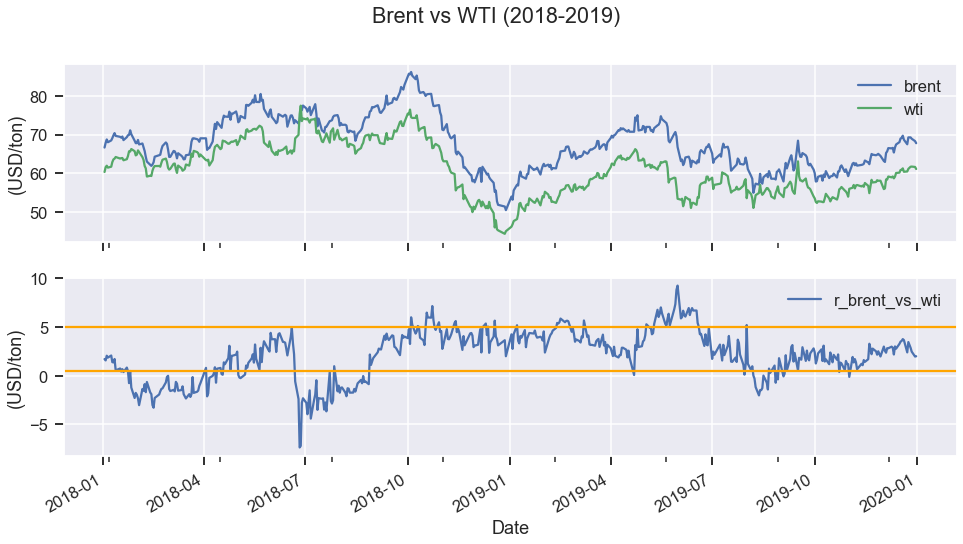

In [93]:
fig, axs = plt.subplots(2,1, sharex=True)

plt.suptitle('Brent vs WTI (2018-2019)')
data['2018':'2019'].plot(y=['brent', 'wti'], ax=axs[0])
data['2018':'2019'].plot(y='r_brent_vs_wti', ax=axs[1])

axs[1].axhline(0.5, color='orange')
axs[1].axhline(5, color='orange')

for ax in axs:
    ax.set_ylabel('(USD/ton)')
plt.show()

In [70]:
data['brent_fret5'] = (data['brent'].shift(-5) - data['brent'])/data['brent']
data[['r_brent_vs_wti', 'brent_fret5']].corr()

,r_brent_vs_wti,brent_fret5
r_brent_vs_wti,1.000000,-0.072709
brent_fret5,-0.072709,1.000000


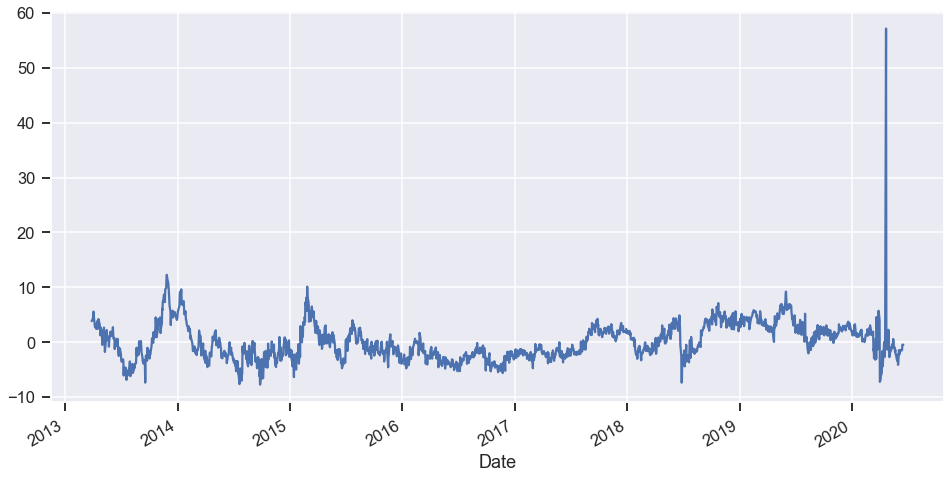

In [50]:
data['r_brent_vs_wti'].plot()